<a href="https://www.kaggle.com/code/parisammm/multilabel-classification-with-bert-stacksample?scriptVersionId=158747811" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stacksample/Answers.csv
/kaggle/input/stacksample/Questions.csv
/kaggle/input/stacksample/Tags.csv


In [4]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics
import transformers
import torch
import seaborn as sns
from bs4 import BeautifulSoup
import string
import re
import nltk
from sklearn.model_selection import train_test_split


In [6]:
from tqdm import tqdm, trange

In [7]:
bert=transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [9]:
from torch import cuda
device= 'cuda' if cuda.is_available() else 'cpu'

In [10]:
df_Questions =  pd.read_csv('/kaggle/input/stacksample/Questions.csv', encoding= 'ISO-8859-1')

In [11]:
df_Answers = pd.read_csv('/kaggle/input/stacksample/Answers.csv', encoding= 'ISO-8859-1')

In [12]:
df_Tags = pd.read_csv('/kaggle/input/stacksample/Tags.csv', encoding= 'ISO-8859-1')

In [13]:
df_Questions.head(10)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...
6,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...
7,580,91.0,2008-08-02T23:30:59Z,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...
8,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...
9,810,233.0,2008-08-03T20:35:01Z,NaN,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...


In [14]:
df_Tags.head(10)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
5,90,branch
6,90,branching-and-merging
7,120,sql
8,120,asp.net
9,120,sitemap


# **Preparing data**

In [15]:
df_TagsSorted= df_Tags['Tag'].value_counts().to_frame()

In [16]:
#occurance of each tag 
df_TagsSorted.columns= ['Tag Occurance']
df_TagsSorted['Tag']= df_TagsSorted.index

In [17]:
#first 30 most used tag
MostCommon_Tag= df_TagsSorted[:30]

In [18]:
df_Tags_new= pd.merge(df_Tags,df_TagsSorted,how= 'left',on='Tag')

In [19]:
df_Tags_new

,Id,Tag,Tag Occurance
0,80,flex,2430.0
1,80,actionscript-3,4039.0
2,80,air,738.0
3,90,svn,2361.0
4,90,tortoisesvn,441.0
...,...,...,...
3750989,40143360,javascript,124155.0
3750990,40143360,vue.js,214.0
3750991,40143380,npm,1084.0
3750992,40143380,mocha,362.0


In [20]:
#extract most used tags that have ocurance more than 14000
df_Tags_new= df_Tags_new[df_Tags_new['Tag Occurance']>=14000]
df_Tags_new

,Id,Tag,Tag Occurance
7,120,sql,35782.0
8,120,asp.net,29970.0
14,260,c#,101186.0
15,260,.net,24059.0
18,330,c++,47591.0
...,...,...,...
3750974,40143150,javascript,124155.0
3750981,40143190,python,64601.0
3750984,40143210,php,98808.0
3750987,40143340,android,90659.0


In [21]:
TagGroup= df_Tags_new.groupby('Id')['Tag'].apply(lambda x: ' '.join(x.astype(str)))

In [22]:
TagGroup.reset_index()

,Id,Tag
0,120,sql asp.net
1,260,c# .net
2,330,c++
3,470,.net
4,580,sql-server
...,...,...
911491,40143150,javascript
911492,40143190,python
911493,40143210,php
911494,40143340,android


In [23]:
QuestionBody= df_Questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate', 'Title'])

In [24]:
MergeTagQuestion= pd.merge(QuestionBody, TagGroup, on= 'Id')

In [25]:
#drop questions that have score less than 5
MergeTagQuestion = MergeTagQuestion[MergeTagQuestion['Score']>5]

In [26]:
MergeTagQuestion = MergeTagQuestion.drop(columns=['Score'])

In [27]:
MergeTagQuestion.drop_duplicates()

,Id,Body,Tag
0,120,<p>Has anyone got experience creating <strong>...,sql asp.net
1,260,<p>I have a little game written in C#. It uses...,c# .net
2,330,<p>I am working on a collection of classes use...,c++
3,470,<p>I've been writing a few web services for a ...,.net
4,580,<p>I wonder how you guys manage deployment of ...,sql-server
...,...,...,...
910451,40106430,<pre><code>#include &lt;cassert&gt;\n\nint mai...,c++
910562,40110020,"<p>It's supposed that ""push_back"" and ""pop_fro...",c++
910614,40111730,"<p>Say, I have given a DataFrame with most of ...",python
910713,40115300,<p>Let's say I have the following code:</p>\n\...,python


In [28]:
#convert tag column to a list of labels
labels= MergeTagQuestion['Tag'].apply(lambda x: (x.split(' ')))

In [29]:
#convert labels to binary labels using sklearn
mlb = MultiLabelBinarizer()
BinaryLabels = mlb.fit_transform(labels)

In [30]:
BinaryLabels

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [31]:
mlb.classes_

array(['.net', 'ajax', 'android', 'angularjs', 'arrays', 'asp.net',
       'asp.net-mvc', 'c', 'c#', 'c++', 'css', 'html', 'ios', 'iphone',
       'java', 'javascript', 'jquery', 'json', 'mysql', 'node.js',
       'objective-c', 'php', 'python', 'r', 'regex', 'ruby',
       'ruby-on-rails', 'sql', 'sql-server', 'xml'], dtype=object)

In [32]:
MergeTagQuestion['BinaryLabels']= BinaryLabels.tolist()

In [33]:
MergeTagQuestion

,Id,Body,Tag,BinaryLabels
0,120,<p>Has anyone got experience creating <strong>...,sql asp.net,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,260,<p>I have a little game written in C#. It uses...,c# .net,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,330,<p>I am working on a collection of classes use...,c++,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,470,<p>I've been writing a few web services for a ...,.net,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,580,<p>I wonder how you guys manage deployment of ...,sql-server,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
910451,40106430,<pre><code>#include &lt;cassert&gt;\n\nint mai...,c++,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
910562,40110020,"<p>It's supposed that ""push_back"" and ""pop_fro...",c++,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
910614,40111730,"<p>Say, I have given a DataFrame with most of ...",python,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
910713,40115300,<p>Let's say I have the following code:</p>\n\...,python,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [34]:
sumTag= BinaryLabels.sum(axis=1)
MultiLabel_count= np.unique(sumTag, return_counts= True)

In [35]:
MultiLabel_count[1].tolist()

[38937, 11530, 1789, 269, 24]

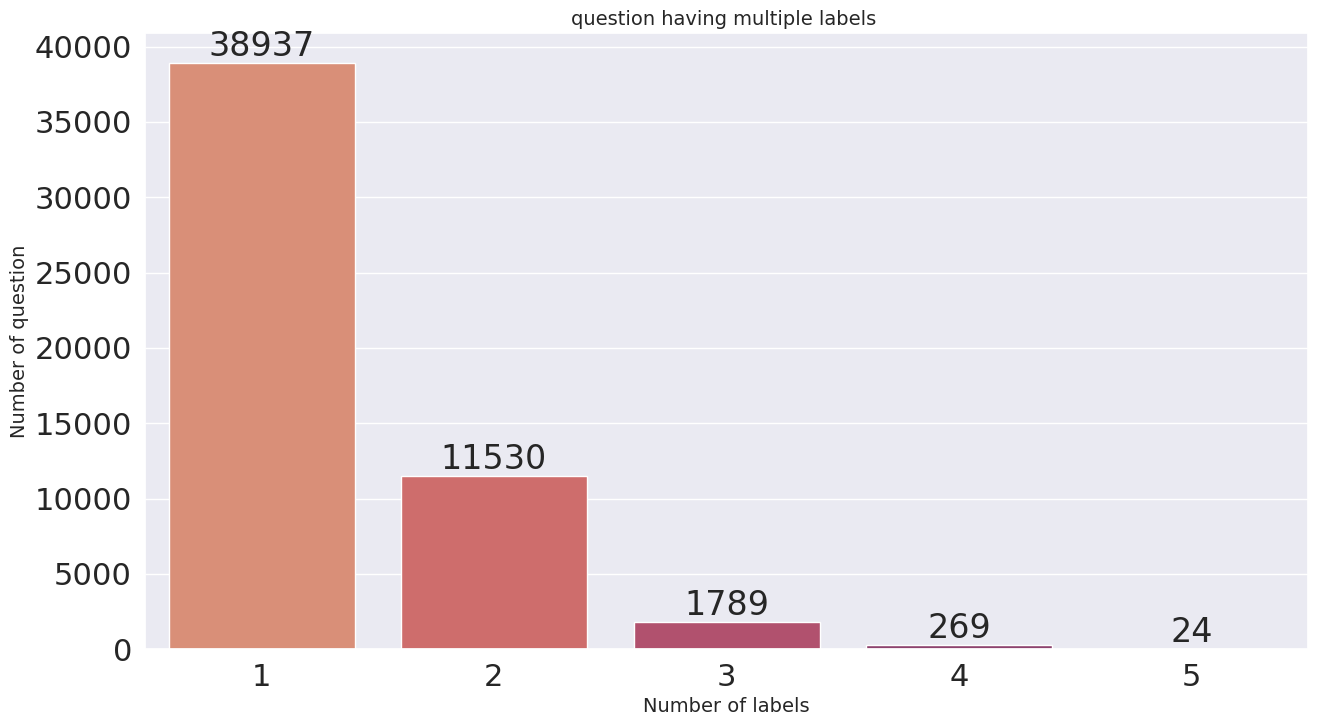

In [36]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(x=MultiLabel_count[0].tolist(), y=MultiLabel_count[1].tolist(), palette= "flare")

plt.title("question having multiple labels ", fontsize=14)

plt.ylabel('Number of question', fontsize=14)
plt.xlabel('Number of labels', fontsize=14)#adding the text labels
rects = ax.patches
labels = MultiLabel_count[1]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [37]:
from nltk.tokenize import ToktokTokenizer

In [38]:
tok_tokenizer = ToktokTokenizer()

# **Cleaning Data**

In [39]:
def cleaning_text(text):
    
    text= BeautifulSoup(text).get_text().strip()
    
    tokenized_text = tok_tokenizer.tokenize(text)
    
    new_text = []
    for word in tokenized_text:
        
        if word in mlb.classes_:
            new_text.append(word)
            
        elif word not in string.punctuation and not word.isdigit():
            new_text.append(word.lower())
            
    return ' '.join(map(str,new_text))

In [40]:
MergeTagQuestion['cleanedBody']= MergeTagQuestion['Body'].apply(lambda x: cleaning_text(x))

In [41]:
MergeTagQuestion

,Id,Body,Tag,BinaryLabels,cleanedBody
0,120,<p>Has anyone got experience creating <strong>...,sql asp.net,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",has anyone got experience creating sql-based a...
1,260,<p>I have a little game written in C#. It uses...,c# .net,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",i have a little game written in c#. it uses a ...
2,330,<p>I am working on a collection of classes use...,c++,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",i am working on a collection of classes used f...
3,470,<p>I've been writing a few web services for a ...,.net,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",i ve been writing a few web services for a .ne...
4,580,<p>I wonder how you guys manage deployment of ...,sql-server,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",i wonder how you guys manage deployment of a d...
...,...,...,...,...,...
910451,40106430,<pre><code>#include &lt;cassert&gt;\n\nint mai...,c++,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",#include <cassert> int main( struct point_of_p...
910562,40110020,"<p>It's supposed that ""push_back"" and ""pop_fro...",c++,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",it s supposed that push_back and pop_front met...
910614,40111730,"<p>Say, I have given a DataFrame with most of ...",python,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",say i have given a dataframe with most of the ...
910713,40115300,<p>Let's say I have the following code:</p>\n\...,python,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","let s say i have the following code a 1,2,3 b ..."


# **Preprocess data for Bert and prepare DataLoader**

In [42]:
class pre_processing(Dataset):
    
    def __init__(self, dataset, tokenizer, max_len):
        
        self.tokenizer = tokenizer
        self.text = dataset.cleanedBody
        self.targets = dataset.BinaryLabels
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
        
    def __getitem__(self, index):
        
        cleaned_text = str(self.text[index])
        cleaned_text = " ".join(cleaned_text.split())
        
        inputs = self.tokenizer.encode_plus(
            cleaned_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True      
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)            
        }
        

In [43]:
#load a small pretrained bert model that has 110M parameters and set some variables for finetunuing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 200
train_size = 0.8
train_batch_size = 8
eval_batch_size = 4
learning_rate = 1e-05
EPOCHS = 3

In [44]:
train_data = MergeTagQuestion.sample(frac= train_size, random_state=200)
eval_data = MergeTagQuestion.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

In [45]:
print('shape of training dataset: {}'.format(train_data.shape))
print('shape of validation dataset: {}'.format(eval_data.shape))

shape of training dataset: (42039, 5)
shape of validation dataset: (10510, 5)


In [46]:
training_data = pre_processing(train_data, tokenizer, MAX_LEN)
evaluation_data = pre_processing(eval_data, tokenizer, MAX_LEN)

In [47]:
traindata_loader = DataLoader(training_data, batch_size=train_batch_size, shuffle=True)
evaldata_loader = DataLoader(evaluation_data, batch_size=eval_batch_size, shuffle=True)

In [57]:
a=next(iter(traindata_loader))
a['ids'].shape

torch.Size([8, 200])

# **Defining model and train**

In [49]:
class BertMultilabel(torch.nn.Module):
    
    def __init__(self, bert, output_dims=30, dropout_rate=0.3):
        
        super(BertMultilabel, self).__init__()
        self.bert = bert
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.linear = torch.nn.Linear( bert.config.to_dict()['hidden_size'], output_dims)
        
    def forward(self, ids, mask, token_type_ids):
        
        output_of_bert = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        x = self.dropout(output_of_bert[1])
        output = self.linear(x)
        return output
        

In [50]:
model = BertMultilabel(bert)
model.to(device)

BertMultilabel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [51]:
#define loss function that is combination of Binary Cross Entropy
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [52]:
def train(epoch):

    tr_loss = 0.0
    tr_step = 0.0
    
    for _ in trange(epoch, desc='Epoch'):
    
        for step ,batch in enumerate (traindata_loader):
                                      
                                      
            model.train()
            ids = batch['ids'].to(device, dtype= torch.long)
            mask = batch['mask'].to(device, dtype= torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype= torch.long)
            targets = batch['targets'].to(device, dtype= torch.float)

            outputs = model(ids, mask, token_type_ids)

            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            
            loss.backward()
            optimizer.step()
            tr_loss += loss.item()
            tr_step += 1
          
        model.eval()

        preds=[]
        label_ids=[]

        with torch.no_grad():
            
            for step ,batch in enumerate (evaldata_loader):        
      
                ids = batch['ids'].to(device, dtype= torch.long)
                mask = batch['mask'].to(device, dtype= torch.long)
                token_type_ids = batch['token_type_ids'].to(device, dtype= torch.long)
                targets = batch['targets'].to(device, dtype= torch.float)
                outputs = model(ids, mask, token_type_ids)

                preds.extend(torch.sigmoid(outputs).detach().cpu().numpy().tolist())
                label_ids.extend(targets.detach().cpu().numpy().tolist())

                preds_out = np.array(preds)>=0.5

        accuracy = metrics.accuracy_score(label_ids, preds_out)
        F1_score_micro = metrics.f1_score(label_ids,preds_out, average='micro',zero_division=0)
        F1_score_macro = metrics.f1_score(label_ids,preds_out, average='macro',zero_division=0)



        print(f'tain_loss={tr_loss/tr_step}')
        print(f'Accuracy={accuracy}')
        print(f'F1_Score_Micro={F1_score_micro}')
        print(f'F1_Score_Macro={F1_score_macro}')



In [58]:
train(EPOCHS)


Epoch:  33%|███▎      | 1/3 [23:56<47:53, 1436.99s/it]

tain_loss=0.08253743179482749
Accuracy=0.5345385347288297
F1_Score_Micro=0.6929570259208732
F1_Score_Macro=0.5471957901663362


Epoch:  67%|██████▋   | 2/3 [47:54<23:57, 1437.37s/it]

tain_loss=0.07046130729872879
Accuracy=0.5744053282588012
F1_Score_Micro=0.7396702463172182
F1_Score_Macro=0.6785596330977975


Epoch: 100%|██████████| 3/3 [1:11:52<00:00, 1437.57s/it]

tain_loss=0.06297001211590594
Accuracy=0.5785918173168411
F1_Score_Micro=0.7521836976007933
F1_Score_Macro=0.707201072796965


# **Prediction**

In [ ]:
def predict(new_sent):
    cleaned_sent = cleaning_text(new_sent)
    
    encoding = tokenizer.encode_plus(
        
        
        cleaned_sent,

        add_special_tokens=True,

        max_length=200,

        return_token_type_ids=False,

        padding="max_length",

        return_attention_mask=True,

        truncation=True,
        
        return_tensors= 'pt'
            

)


    
    ids_test = encoding['input_ids']
    mask_test = encoding['attention_mask']
     
    with torch.no_grad():
        
        outputs = model(ids_test.to(device),  mask_test.to(device), token_type_ids=None)
        
        preds = torch.sigmoid(outputs).detach().cpu().numpy().flatten()
        
    return preds


In [ ]:
new_sent='Does PyTorch distinguish between different types of NaN like C++ does?'
predict_out = predict(new_sent)

score_of_labels={}

for label,prediction in zip(mlb.classes_ , predict_out):
#     if (prediction)<0.3:
#         continue
    score_of_labels[label]=prediction
print(sorted(score_of_labels, key= score_of_labels.get, reverse=True ))